# Getting started

In this notebook, we use `TorchSurv` to train a model that predicts relative risk of breast cancer recurrence. We use a public data set, the [German Breast Cancer Study Group 2 (GBSG2)](https://paperswithcode.com/dataset/gbsg2). After training the model, we evaluate the predictive performance using evaluation metrics implemented in `TorchSurv`.


We first load the dataset using the package [lifelines](https://lifelines.readthedocs.io/en/latest/). The GBSG2 dataset contains features and recurrence free survival time (in days) for 686 women undergoing hormonal treatment. 

### Dependencies

To run this notebook, dependencies must be installed. the recommended method is to use our developpment conda environment (**preffered**). Instruction can be found [here](https://opensource.nibr.com/torchsurv/devnotes.html#set-up-a-development-environment-via-conda) to install all optional dependancies. The other method is to install only required packages using the command line below:

In [1]:
# Install only required packages (optional)
# %pip install lifelines
# %pip install matplotlib
# %pip install sklearn
# %pip install pandas

### Installation

On local machine (Carbon X1) installed from repo into conda env: _ptorch_:

```sh
git clone https://github.com/Novartis/torchsurv.git
cd torchsurv
pip install -e .
```

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import lifelines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Our package
from torchsurv.loss.cox import neg_partial_log_likelihood
from torchsurv.loss.weibull import neg_log_likelihood, log_hazard, survival_function
from torchsurv.metrics.brier_score import BrierScore
from torchsurv.metrics.cindex import ConcordanceIndex
from torchsurv.metrics.auc import Auc
from torchsurv.stats.kaplan_meier import KaplanMeierEstimator

# PyTorch boilerplate - see https://github.com/Novartis/torchsurv/blob/main/docs/notebooks/helpers_introduction.py
#from helpers_introduction import Custom_dataset, plot_losses

In [3]:
# Constant parameters accross models
# Detect available accelerator; Downgrade batch size if only CPU available
if any([torch.cuda.is_available(), torch.backends.mps.is_available()]):
    print("CUDA-enabled GPU/TPU is available.")
    BATCH_SIZE = 128  # batch size for training
else:
    print("No CUDA-enabled GPU found, using CPU.")
    BATCH_SIZE = 64# 32  # batch size for training

EPOCHS = 100
LEARNING_RATE = 1e-2

No CUDA-enabled GPU found, using CPU.


In [6]:
from torch.utils.data import Dataset

class Custom_dataset(Dataset):
    """ "Custom dataset for the GSBG2 brain cancer dataset"""

    # defining values in the constructor
    def __init__(self, df: pd.DataFrame):
        self.df = df

    # Getting data size/length
    def __len__(self):
        return len(self.df)

    # Getting the data samples
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        # Targets
        event = torch.tensor(sample["cens"]).bool()
        time = torch.tensor(sample["time"]).float()
        # Predictors
        x = torch.tensor(sample.drop(["cens", "time"]).values).float()
        return x, (event, time)

import matplotlib.pyplot as plt
import pandas as pd

def plot_losses(train_losses, val_losses, title: str = "Cox") -> None:

    train_losses = torch.stack(train_losses) / train_losses[0]
    val_losses = torch.stack(val_losses) / val_losses[0]

    plt.plot(train_losses, label="training")
    plt.plot(val_losses, label="validation")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Normalized loss")
    plt.title(title)
    plt.yscale("log")
    plt.show()


## Dataset overview

In [7]:
# Load GBSG2 dataset
df = lifelines.datasets.load_gbsg2()
df.head(5)

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


The dataset contains the categorical features: 

- `horTh`: hormonal therapy, a factor at two levels (yes and no).
- `age`:  age of the patients in years.
- `menostat`: menopausal status, a factor at two levels pre (premenopausal) and post (postmenopausal).
- `tsize`: tumor size (in mm).
- `tgrade`: tumor grade, a ordered factor at levels I < II < III.
- `pnodes`: number of positive nodes.
- `progrec`: progesterone receptor (in fmol).
- `estrec`: estrogen receptor (in fmol).

Additionally, it contains our survival targets:

- `time`: recurrence free survival time (in days).
- `cens`: censoring indicator (0- censored, 1- event).

One common approach is to use a [one hot encoder](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to convert them into numerical features. We then seperate the dataframes into features `X` and labels `y`. The following code also partitions the labels and features into training and testing cohorts.

## Data preparation

In [8]:
df_onehot = pd.get_dummies(df, columns=["horTh", "menostat", "tgrade"]).astype("float")
df_onehot.drop(
    ["horTh_no", "menostat_Post", "tgrade_I"],
    axis=1,
    inplace=True,
)
df_onehot.head(5)

,age,tsize,pnodes,progrec,estrec,time,cens,horTh_yes,menostat_Pre,tgrade_II,tgrade_III
0,70.0,21.0,3.0,48.0,66.0,1814.0,1.0,0.0,0.0,1.0,0.0
1,56.0,12.0,7.0,61.0,77.0,2018.0,1.0,1.0,0.0,1.0,0.0
2,58.0,35.0,9.0,52.0,271.0,712.0,1.0,1.0,0.0,1.0,0.0
3,59.0,17.0,4.0,60.0,29.0,1807.0,1.0,1.0,0.0,1.0,0.0
4,73.0,35.0,1.0,26.0,65.0,772.0,1.0,0.0,0.0,1.0,0.0


In [9]:
df_train, df_test = train_test_split(df_onehot, test_size=0.3)
df_train, df_val = train_test_split(df_train, test_size=0.3)
print(
    f"(Sample size) Training:{len(df_train)} | Validation:{len(df_val)} |Testing:{len(df_test)}"
)

(Sample size) Training:336 | Validation:144 |Testing:206


Let us setup the dataloaders for training, validation and testing.

In [10]:
# Dataloader
dataloader_train = DataLoader(
    Custom_dataset(df_train), batch_size=BATCH_SIZE, shuffle=True
)
dataloader_val = DataLoader(
    Custom_dataset(df_val), batch_size=len(df_val), shuffle=False
)
dataloader_test = DataLoader(
    Custom_dataset(df_test), batch_size=len(df_test), shuffle=False
)

In [11]:
# Sanity check
x, (event, time) = next(iter(dataloader_train))
num_features = x.size(1)

print(f"x (shape)    = {x.shape}")
print(f"num_features = {num_features}")
print(f"event        = {event.shape}")
print(f"time         = {time.shape}")

x (shape)    = torch.Size([64, 9])
num_features = 9
event        = torch.Size([64])
time         = torch.Size([64])


In [25]:
df_train.head(5)

,age,tsize,pnodes,progrec,estrec,time,cens,horTh_yes,menostat_Pre,tgrade_II,tgrade_III
192,52.0,40.0,6.0,32.0,5.0,241.0,1.0,0.0,1.0,0.0,1.0
179,70.0,18.0,1.0,107.0,307.0,734.0,0.0,1.0,0.0,1.0,0.0
208,52.0,10.0,3.0,109.0,12.0,1897.0,0.0,0.0,0.0,1.0,0.0
158,62.0,25.0,5.0,0.0,0.0,1225.0,1.0,0.0,0.0,0.0,1.0
596,51.0,42.0,7.0,58.0,75.0,1078.0,0.0,1.0,0.0,1.0,0.0


<lifelines.CoxPHFitter: fitted with 336 total observations, 188 right-censored observations>
             duration col = 'time'
                event col = 'cens'
      baseline estimation = breslow
   number of observations = 336
number of events observed = 148
   partial log-likelihood = -740.72
         time fit was run = 2025-05-05 14:08:21 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
age          -0.04      0.96      0.01           -0.07           -0.02                0.93                0.99
tsize         0.00      1.00      0.01           -0.01            0.02                0.99                1.02
pnodes        0.09      1.10      0.01            0.07            0.12                1.07                1.13
progrec      -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
estrec       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
horTh_yes    -0.44      0.65      0.19           -0.80           -0.07                0.45                0.94
menostat_Pre -0.65      0.52      0.27           -1.18           -0.12                0.31                0.89
tgrade_II     0.77      2.16      0.37            0.04            1.50                1.04                4.50
tgrade_III    1.05      2.85      0.40            0.26            1.83                1.30                6.23

              cmp to     z      p  -log2(p)
covariate                                  
age             0.00 -3.05 <0.005      8.79
tsize           0.00  0.88   0.38      1.40
pnodes          0.00  6.62 <0.005     34.71
progrec         0.00 -2.20   0.03      5.18
estrec          0.00 -0.23   0.81      0.30
horTh_yes       0.00 -2.31   0.02      5.57
menostat_Pre    0.00 -2.41   0.02      5.96
tgrade_II       0.00  2.06   0.04      4.65
tgrade_III      0.00  2.61   0.01      6.81
---
Concordance = 0.72
Partial AIC = 1499.45
log-likelihood ratio test = 79.45 on 9 df
-log2(p) of ll-ratio test = 42.13

<Axes: >

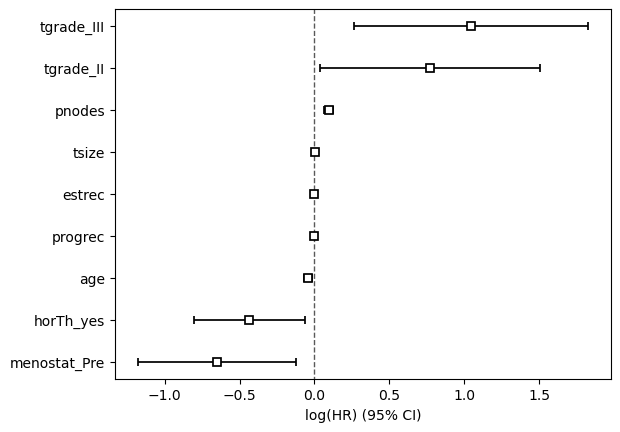

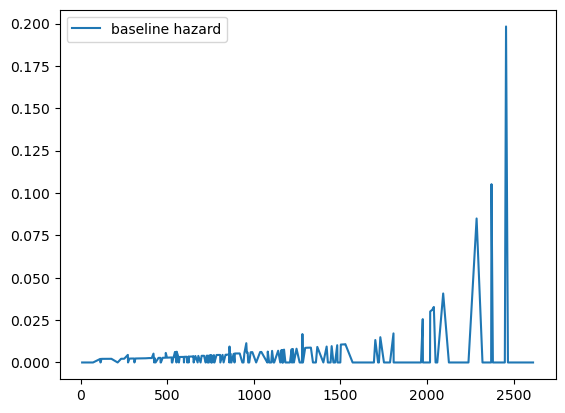

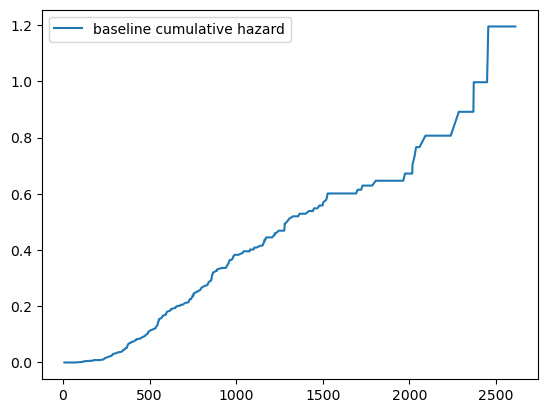

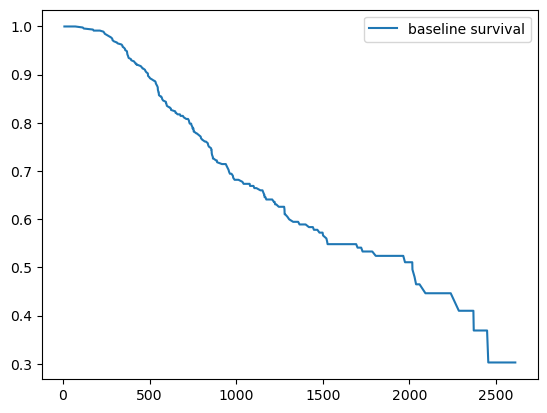

In [43]:
# Ccompute baseline (for Cox PH)
cph = lifelines.CoxPHFitter()
cph.fit(df_train, duration_col='time', event_col='cens')
#cph.fit(df_train, duration_col='time', event_col='cens', strata=["menostat_Pre"])

cph.print_summary()  # print the results
cph.plot()  # plot the coefficients

cph.baseline_hazard_.plot()
cph.baseline_cumulative_hazard_.plot()
cph.baseline_survival_.plot()


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plo

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 336 total observations, 188 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic    p  -log2(p)
age          km              3.40 0.07      3.93
             rank            3.33 0.07      3.88
estrec       km              0.32 0.57      0.81
             rank            0.50 0.48      1.06
horTh_yes    km              0.76 0.38      1.39
             rank            0.74 0.39      1.36
menostat_Pre km              0.03 0.86      0.22
             rank            0.03 0.86      0.22
pnodes       km              1.69 0.19      2.37
             rank            1.91 0.17      2.59
progrec      km              3.24 0.07      3.80
             rank            2.91 0.09      3.51
tgrade_II    km              0.82 0.37      1.45
             rank            1.17 0.28      1.84
tgrade_III   km              3.33 0.07      3.87
             rank            4.34 0.04      4.74
tsize        km              0.17 0.68      0.56
             rank            0.21 0.65      0.62



1. Variable 'tgrade_III' failed the non-proportional test: p-value is 0.0373.

   Advice: with so few unique values (only 2), you can include `strata=['tgrade_III', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<Axes: xlabel='rank-transformed time\n(p=0.0679)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0654)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6505)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6768)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1666)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1940)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0878)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0719)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4806)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5702)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3908)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3819)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8588)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8584)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2793)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3654)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0373)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0682)'>]]

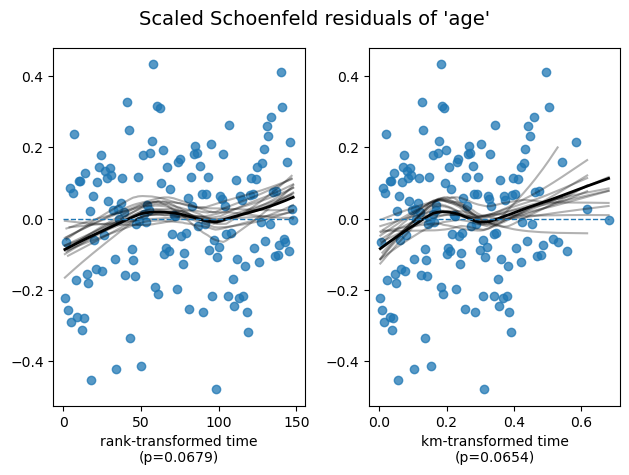

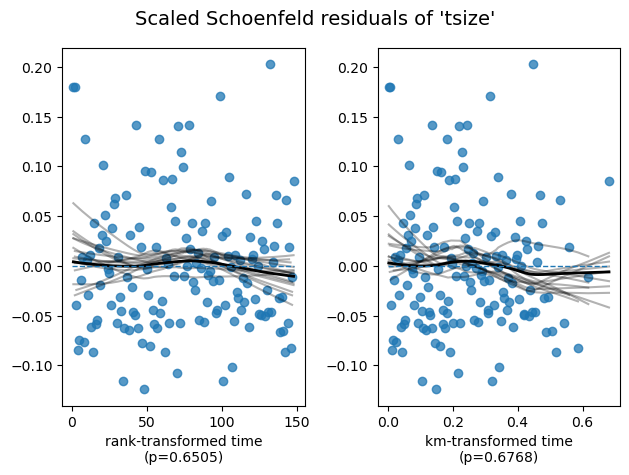

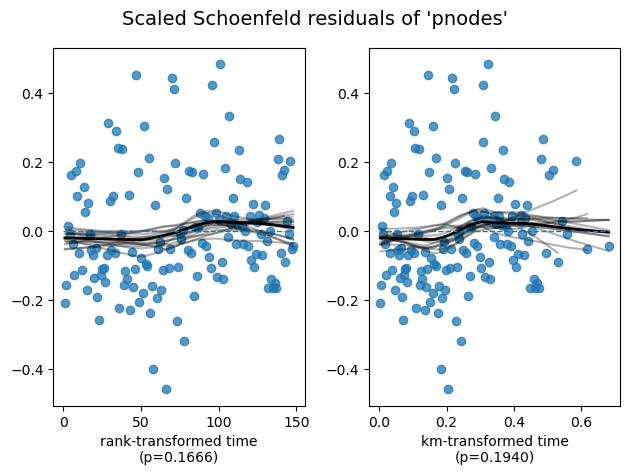

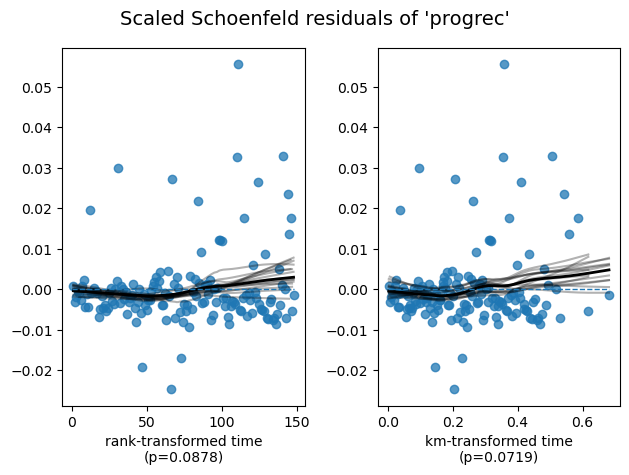

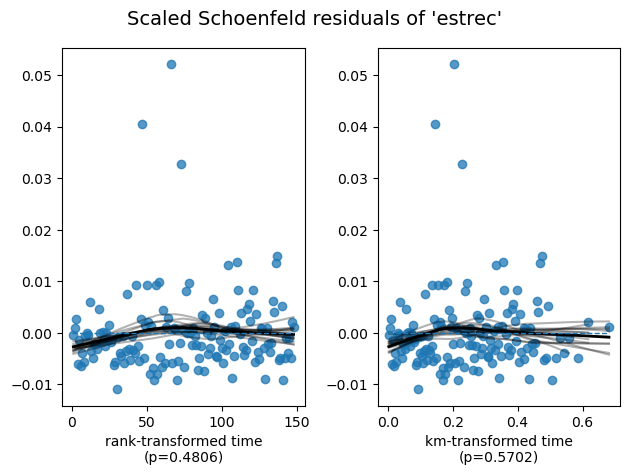

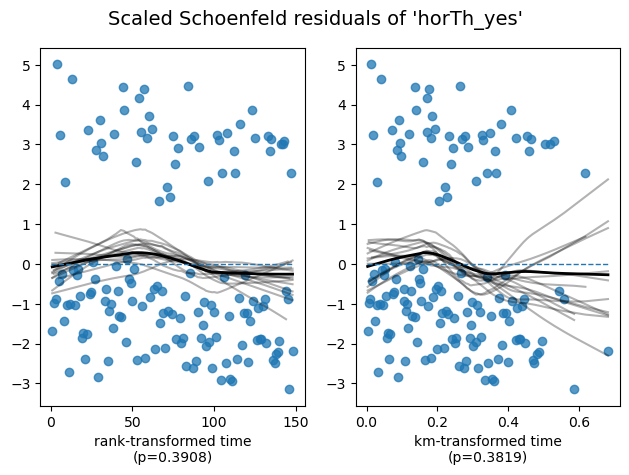

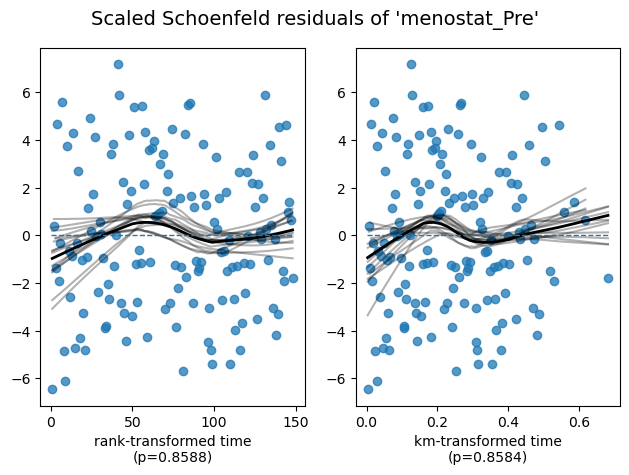

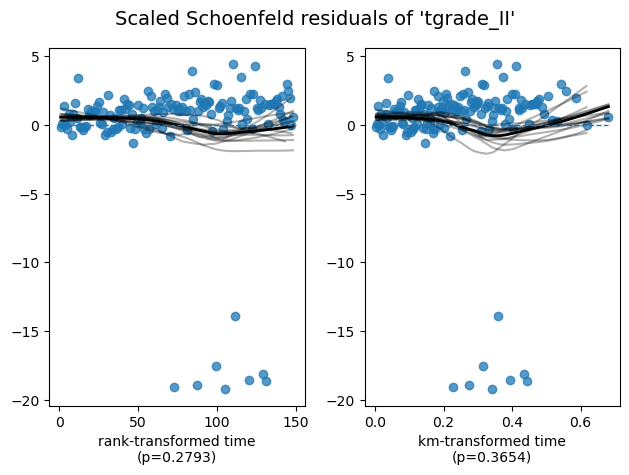

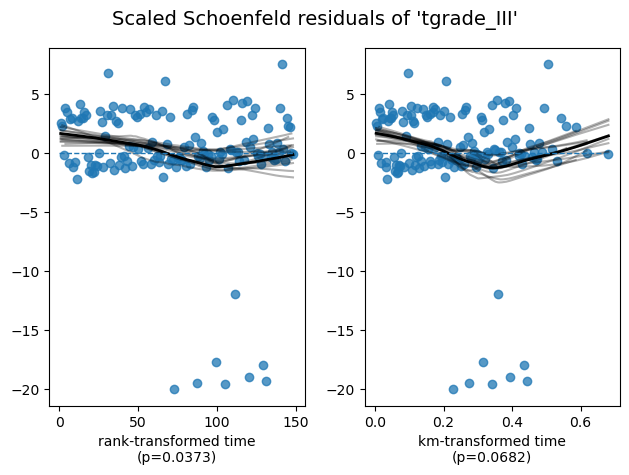

In [44]:
# Check proportional hazards assumption
cph.check_assumptions(df_train, p_value_threshold=0.05, show_plots=True)

## Section 1: Cox proportional hazards model

In this section, we use the [Cox proportional hazards model](../_autosummary/torchsurv.loss.cox.html). Given covariate $x_{i}$, the hazard of patient $i$ has the form
$$
\lambda (t|x_{i}) =\lambda_{0}(t)\theta(x_{i})
$$
The baseline hazard $\lambda_{0}(t)$ is identical across subjects (i.e., has no dependency on $i$). The subject-specific risk of event occurrence is captured through the relative hazards $\{\theta(x_{i})\}_{i = 1, \dots, N}$.

We train a multi-layer perceptron (MLP) to model the subject-specific risk of event occurrence, i.e., the log relative hazards $\log\theta(x_{i})$. Patients with lower recurrence time are assumed to have higher risk of event. 

### Section 1.1: MLP model for log relative hazards

In [12]:
cox_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 1),  # Estimating log hazards for Cox models
)

### Section 1.2: MLP model training

In [13]:
torch.manual_seed(42)

# Init optimizer for Cox
optimizer = torch.optim.Adam(cox_model.parameters(), lr=LEARNING_RATE)

# Initiate empty list to store the loss on the train and validation sets
train_losses = []
val_losses = []

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for i, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        optimizer.zero_grad()
        log_hz = cox_model(x)  # shape = (16, 1)
        loss = neg_partial_log_likelihood(log_hz, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Reccord loss on train and test sets
    epoch_loss /= i + 1
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        val_losses.append(
            neg_partial_log_likelihood(cox_model(x), event, time, reduction="mean")
        )

Epoch: 000, Training loss: 20.87
Epoch: 010, Training loss: 19.44
Epoch: 020, Training loss: 19.12
Epoch: 030, Training loss: 19.28
Epoch: 040, Training loss: 19.63
Epoch: 050, Training loss: 18.87
Epoch: 060, Training loss: 19.99
Epoch: 070, Training loss: 18.71
Epoch: 080, Training loss: 18.28
Epoch: 090, Training loss: 18.75


We can visualize the training and validation losses.

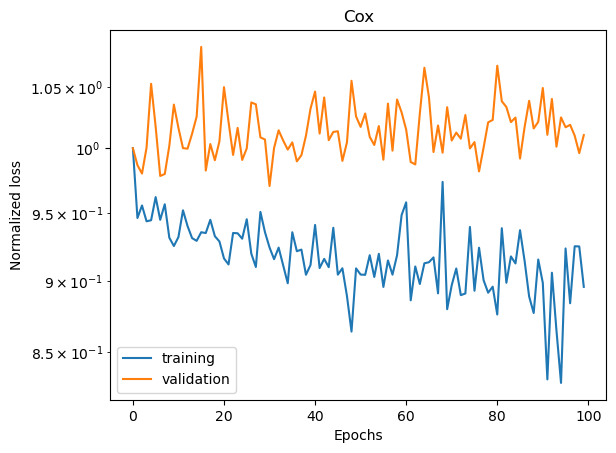

In [14]:
plot_losses(train_losses, val_losses, "Cox")

### Section 1.3: Cox proportional hazards model evaluation

We evaluate the predictive performance of the model using 

* the [concordance index](../_autosummary/torchsurv.metrics.cindex.html) (C-index), which measures the the probability that a model correctly predicts which of two comparable samples will experience an event first based on their estimated risk scores,
* the [Area Under the Receiver Operating Characteristic Curve](../_autosummary/torchsurv.metrics.auc.html) (AUC), which measures the probability that a model correctly predicts which of two comparable samples will experience an event by time t based on their estimated risk scores.

We cannot use the Brier score because this model is not able to estimate the survival function.

We start by evaluating the subject-specific relative hazards on the test set 

In [15]:
cox_model.eval()
with torch.no_grad():
    # test event and test time of length n
    x, (event, time) = next(iter(dataloader_test))
    log_hz = cox_model(x)  # log hazard of length n

In [24]:
log_hz.shape

torch.Size([206, 1])

We obtain the concordance index, and its confidence interval

In [16]:
# Concordance index
cox_cindex = ConcordanceIndex()
print("Cox model performance:")
print(f"Concordance-index   = {cox_cindex(log_hz, event, time)}")
print(f"Confidence interval = {cox_cindex.confidence_interval()}")

Cox model performance:
Concordance-index   = 0.662530779838562
Confidence interval = tensor([0.5410, 0.7840])


We can also test whether the observed concordance index is greater than 0.5. The statistical test is specified with H0: c-index = 0.5 and Ha: c-index > 0.5. The p-value of the statistical test is

In [17]:
# H0: cindex = 0.5, Ha: cindex > 0.5
print("p-value = {}".format(cox_cindex.p_value(alternative="greater")))

p-value = 0.004371166229248047


For time-dependent prediction (e.g., 5-year mortality), the C-index is not a proper measure. Instead, it is recommended to use the AUC. The probability to correctly predicts which of two comparable patients will experience an event by 5-year based on their estimated risk scores is the AUC evaluated at 5-year (1825 days) obtained with

In [18]:
cox_auc = Auc()

new_time = torch.tensor(1825.0)

# auc evaluated at new time = 1825, 5 year
print(f"AUC 5-yr             = {cox_auc(log_hz, event, time, new_time=new_time)}")
print(f"AUC 5-yr (conf int.) = {cox_auc.confidence_interval()}")

AUC 5-yr             = tensor([0.7703])
AUC 5-yr (conf int.) = tensor([0.7086, 0.8320])


As before, we can test whether the observed Auc at 5-year is greater than 0.5. The statistical test is specified with H0: auc = 0.5 and Ha: auc > 0.5. The p-value of the statistical test is

In [19]:
print(f"AUC (p_value) = {cox_auc.p_value()}")

AUC (p_value) = tensor([0.])


## Section 2: Weibull accelerated failure time (AFT) model

In this section, we use the [Weibull accelerated failure (AFT) model](../_autosummary/torchsurv.loss.weibull.html). Given covariate $x_{i}$, the hazard of patient $i$ at time $t$ has the form
$$
\lambda (t|x_{i}) = \frac{\rho(x_{i}) } {\lambda(x_{i}) } + \left(\frac{t}{\lambda(x_{i})}\right)^{\rho(x_{i}) - 1}
$$

Given the hazard form, it can be shown that the event density follows a Weibull distribution parametrized by scale $\lambda(x_{i})$ and shape $\rho(x_{i})$. The subject-specific risk of event occurrence at time $t$ is captured through the hazards $\{\lambda (t|x_{i})\}_{i = 1, \dots, N}$. We train a multi-layer perceptron (MLP) to model the subject-specific log scale, $\log \lambda(x_{i})$, and the log shape, $\log\rho(x_{i})$. 

### Section 2.1: MLP model for log scale and log shape

In [40]:
# Same architecture than Cox model, beside outputs dimension
weibull_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 2),  # Estimating log parameters for Weibull model
)

### Section 2.2: MLP model training

In [41]:
torch.manual_seed(42)

# Init optimizer for Weibull
optimizer = torch.optim.Adam(weibull_model.parameters(), lr=LEARNING_RATE)

# Initialize empty list to store loss on train and validation sets
train_losses = []
val_losses = []

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for i, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        optimizer.zero_grad()
        log_params = weibull_model(x)  # shape = (16, 2)
        loss = neg_log_likelihood(log_params, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Reccord losses for the following figure
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        val_losses.append(
            neg_log_likelihood(weibull_model(x), event, time, reduction="mean")
        )

Epoch: 000, Training loss: 851.61
Epoch: 010, Training loss: 38.83
Epoch: 020, Training loss: 36.54
Epoch: 030, Training loss: 37.45
Epoch: 040, Training loss: 35.40
Epoch: 050, Training loss: 34.05
Epoch: 060, Training loss: 32.33
Epoch: 070, Training loss: 30.49
Epoch: 080, Training loss: 30.42
Epoch: 090, Training loss: 27.68


We can visualize the training and validation losses.

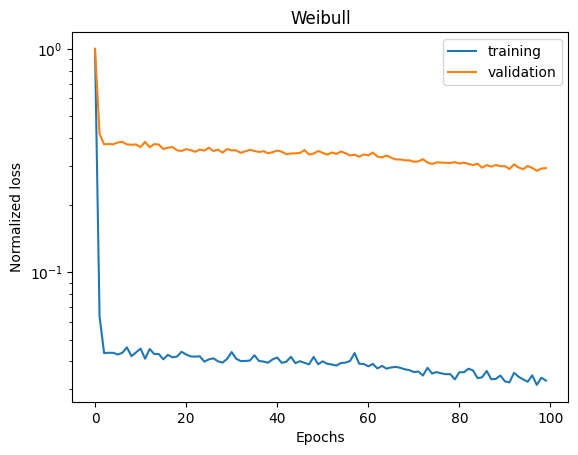

In [42]:
plot_losses(train_losses, val_losses, "Weibull")

### Section 2.3: Weibull AFT model evaluation

We evaluate the predictive performance of the model using 

* the [C-index](../_autosummary/torchsurv.metrics.cindex.html), which measures the the probability that a model correctly predicts which of two comparable samples will experience an event first based on their estimated risk scores,
* the [AUC](../_autosummary/torchsurv.metrics.auc.html), which measures the probability that a model correctly predicts which of two comparable samples will experience an event by time t based on their estimated risk scores, and
* the [Brier score](../_autosummary/torchsurv.metrics.brier_score.html), which measures the model's calibration by calculating the mean square error between the estimated survival function and the empirical (i.e., in-sample) event status.

We start by obtaining the subject-specific log hazard and survival probability at every time $t$ observed on the test set

In [43]:
weibull_model.eval()
with torch.no_grad():
    # event and time of length n
    x, (event, time) = next(iter(dataloader_test))
    log_params = weibull_model(x)  # shape = (n,2)

# Compute the log hazards from weibull log parameters
log_hz = log_hazard(log_params, time)  # shape = (n,n)

# Compute the survival probability from weibull log parameters
surv = survival_function(log_params, time)  # shape = (n,n)

We can evaluate the concordance index, its confidence interval and the p-value of the statistical test testing whether the c-index is greater than 0.5:

In [72]:
len(time2)

8

torch.Size([501, 206])


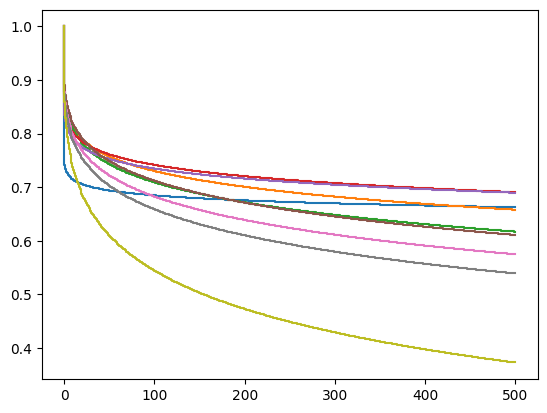

In [102]:
time2 = [0,1,2,5, 10,20, 50, 100]
time2 = range(0,501,1)
#surv2 = survival_function(log_params, time2, all_times = False) 
surv2 = torch.empty(206)
surv_list = []
for t in time2:
    survt = survival_function(log_params, time = torch.tensor(t))
    #print(survt.shape)
    surv_list.append(survt.unsqueeze(1))

surv2 = torch.cat(surv_list, dim=1).transpose(0, 1)
print(surv2.shape)
#display(surv2)
#plt.plot(time, surv2);
for i in range(x.shape[1]):
    plt.step(time2, surv2[:,i].numpy())
plt.show()

In [44]:
# Concordance index
weibull_cindex = ConcordanceIndex()
print("Weibull model performance:")
print(f"Concordance-index   = {weibull_cindex(log_hz, event, time)}")
print(f"Confidence interval = {weibull_cindex.confidence_interval()}")

# H0: cindex = 0.5, Ha: cindex >0.5
print(f"p-value             = {weibull_cindex.p_value(alternative = 'greater')}")

Weibull model performance:
Concordance-index   = 0.6540836095809937
Confidence interval = tensor([0.5337, 0.7744])
p-value             = 0.006044149398803711


For time-dependent prediction (e.g., 5-year mortality), the C-index is not a proper measure. Instead, it is recommended to use the AUC. The probability to correctly predicts which of two comparable patients will experience an event by 5-year based on their estimated risk scores is the AUC evaluated at 5-year (1825 days) obtained with

In [45]:
new_time = torch.tensor(1825.0)

# subject-specific log hazard at \5-yr
log_hz_t = log_hazard(log_params, time=new_time)  # shape = (n)
weibull_auc = Auc()

# auc evaluated at new time = 1825, 5 year
print(f"AUC 5-yr             = {weibull_auc(log_hz_t, event, time, new_time=new_time)}")
print(f"AUC 5-yr (conf int.) = {weibull_auc.confidence_interval()}")
print(f"AUC 5-yr (p value)   = {weibull_auc.p_value(alternative='greater')}")

AUC 5-yr             = tensor([0.7430])
AUC 5-yr (conf int.) = tensor([0.6852, 0.8009])
AUC 5-yr (p value)   = tensor([0.])


Lastly, we can evaluate the time-dependent Brier score and the integrated Brier score

In [46]:
brier_score = BrierScore()

# brier score at first 5 times
print(f"Brier score             = {brier_score(surv, event, time)[:5]}")
print(f"Brier score (conf int.) = {brier_score.confidence_interval()[:,:5]}")

# integrated brier score
print(f"Integrated Brier score  = {brier_score.integral()}")

Brier score             = tensor([0.0587, 0.0814, 0.0871, 0.0905, 0.0908])
Brier score (conf int.) = tensor([[0.0547, 0.0769, 0.0824, 0.0855, 0.0858],
        [0.0627, 0.0859, 0.0918, 0.0954, 0.0959]])
Integrated Brier score  = 0.1458197683095932


We can test whether the time-dependent Brier score is smaller than what would be expected if the survival model was not providing accurate predictions beyond random chance. We use a bootstrap permutation test and obtain the p-value with:

In [47]:
# H0: bs = bs0, Ha: bs < bs0; where bs0 is the expected brier score if the survival model was not providing accurate predictions beyond random chance.

# p-value for brier score at first 5 times
print(f"Brier score (p-val)        = {brier_score.p_value(alternative = 'less')[:5]}")

Brier score (p-val)        = tensor([0.9000, 0.8840, 0.9330, 0.8620, 0.7420])


## Section 3: Models comparison

We can compare the predictive performance of the Cox proportional hazards model against the Weibull AFT model.

### Section 3.1: Concordance index
The statistical test is formulated as follows, H0: cindex cox = cindex weibull, Ha: cindex cox > cindex weibull

In [48]:
print(f"Cox cindex     = {cox_cindex.cindex}")
print(f"Weibull cindex = {weibull_cindex.cindex}")
print("p-value        = {}".format(cox_cindex.compare(weibull_cindex)))

Cox cindex     = 0.6883048415184021
Weibull cindex = 0.6540836095809937
p-value        = 0.2965618968009949


### Section 3.2: AUC at 5-year

The statistical test is formulated as follows, H0: 5-yr auc cox = 5-yr auc weibull, Ha: 5-yr auc cox > 5-yr auc weibull

In [49]:
print(f"Cox 5-yr AUC     = {cox_auc.auc}")
print(f"Weibull 5-yr AUC = {weibull_auc.auc}")
print("p-value          = {}".format(cox_auc.compare(weibull_auc)))

Cox 5-yr AUC     = tensor([0.7417])
Weibull 5-yr AUC = tensor([0.7430])
p-value          = tensor([0.5223])


## Section 4: Kaplan Meier


In [50]:
# Create a Kaplan-Meier estimator
km = KaplanMeierEstimator()

# Use our observed testing dataset
event = torch.tensor(df_test["cens"].values).bool()
time = torch.tensor(df_test["time"].values)

# Compute the estimator
km(event, time)

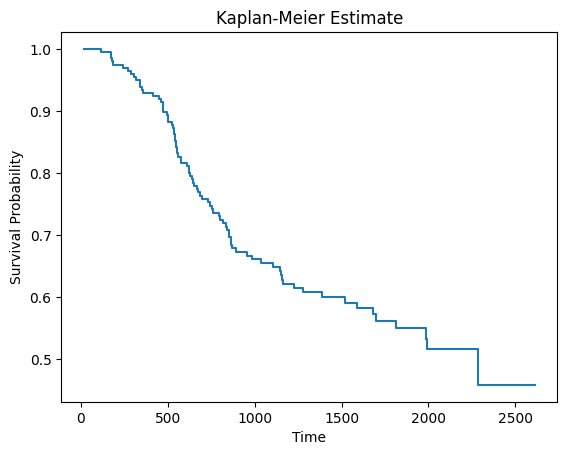

In [51]:
# plot estimate
km.plot_km()

In [30]:
# Print the survival values at each time step
km.print_survival_table()

Time	Survival
----------------
16.00	1.0000
17.00	1.0000
18.00	1.0000
98.00	0.9951
113.00	0.9901
160.00	0.9852
177.00	0.9803
180.00	0.9753
181.00	0.9704
186.00	0.9704
191.00	0.9654
195.00	0.9604
223.00	0.9555
241.00	0.9505
247.00	0.9455
251.00	0.9405
273.00	0.9405
276.00	0.9405
286.00	0.9355
308.00	0.9305
316.00	0.9254
338.00	0.9204
343.00	0.9154
348.00	0.9104
350.00	0.9053
353.00	0.9003
358.00	0.8953
371.00	0.8902
377.00	0.8852
415.00	0.8802
420.00	0.8752
424.00	0.8752
426.00	0.8701
448.00	0.8650
460.00	0.8600
463.00	0.8600
475.00	0.8549
476.00	0.8498
481.00	0.8447
490.00	0.8396
515.00	0.8345
526.00	0.8345
536.00	0.8294
541.00	0.8294
544.00	0.8243
545.00	0.8191
547.00	0.8140
548.00	0.8088
552.00	0.8037
554.00	0.7985
559.00	0.7934
570.00	0.7934
573.00	0.7882
575.00	0.7830
578.00	0.7778
594.00	0.7726
596.00	0.7726
623.00	0.7726
624.00	0.7674
632.00	0.7621
637.00	0.7621
650.00	0.7568
657.00	0.7568
662.00	0.7515
687.00	0.7461
730.00	0.7408
733.00	0.7408
734.00	0.7408
737.00	0.7408
740.00	